# BUILDING AND TRAINING THE MODEL

#### Importing Relevant libraries

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import librosa
import librosa.display

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten

#### Function to save Spectrograms as Image Files

In [78]:
def create_spectrograms(file_path, output_path):
    audio_data, sample_rate = librosa.load(file_path, sr=None)  
    S = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sample_rate, hop_length=512, x_axis=None, y_axis=None)  # Remove x and y axes
    plt.axis('off')  # Turn off the axis
    plt.tight_layout(pad=0)

    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

#### Seperating Audio Files and its Labels

In [31]:
X = df['Dataset File Name']
Y = df['Class Name']
labels = df['Class Name'].unique()

#### Creating Directories to Store Saved Spectrograms for Training and Testing 

In [33]:
training_dir = 'spectrogram/train/'
testing_dir = 'spectrogram/test/'
os.makedirs(training_dir, exist_ok=True)
os.makedirs(testing_dir, exist_ok=True)

#### Seperating Training and Testing Data

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

for label in labels:  # 27 labels
    label_training_dir = os.path.join(training_dir, label)
    label_testing_dir = os.path.join(testing_dir, label)
    os.makedirs(label_training_dir, exist_ok=True)
    os.makedirs(label_testing_dir, exist_ok=True)

#### Generating Spectrograms

In [39]:
# Generating spectrograms and saving to the appropriate directories
for wav_file, y in zip(X_train, y_train):
    if wav_file.endswith('.wav'):
        training_path = training_dir + y + "/" + wav_file[:-4] + ".png"
        create_spectrograms(r"C:\Users\kanis\Downloads\Audio Files/"+wav_file, training_path)

for wav_file, y in zip(X_test, y_test):
    if wav_file.endswith('.wav'):
        testing_path = testing_dir + y + "/" + wav_file[:-4] + ".png"
        create_spectrograms(r"C:\Users\kanis\Downloads\Audio Files/"+wav_file, testing_path)

C:\Users\kanis\anaconda3\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [47]:
print(os.getcwd())

C:\Users\kanis\audio data


#### Batch Loading of Data

In [51]:
# generators(to process large amount of data) - Divide data into batches(only one batch loads in the RAM and when it is used it gets removed and new batch is loaded)
train_data = keras.utils.image_dataset_from_directory(
    directory=r"C:\Users\kanis\audio data\spectrogram\train",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(256,256)
)

validation_data = train_data = keras.utils.image_dataset_from_directory(
    directory=r"C:\Users\kanis\audio data\spectrogram\test",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(256,256)
)

Found 1621 files belonging to 27 classes.
Found 405 files belonging to 27 classes.


#### Visualizing Audio alongwith their Labels

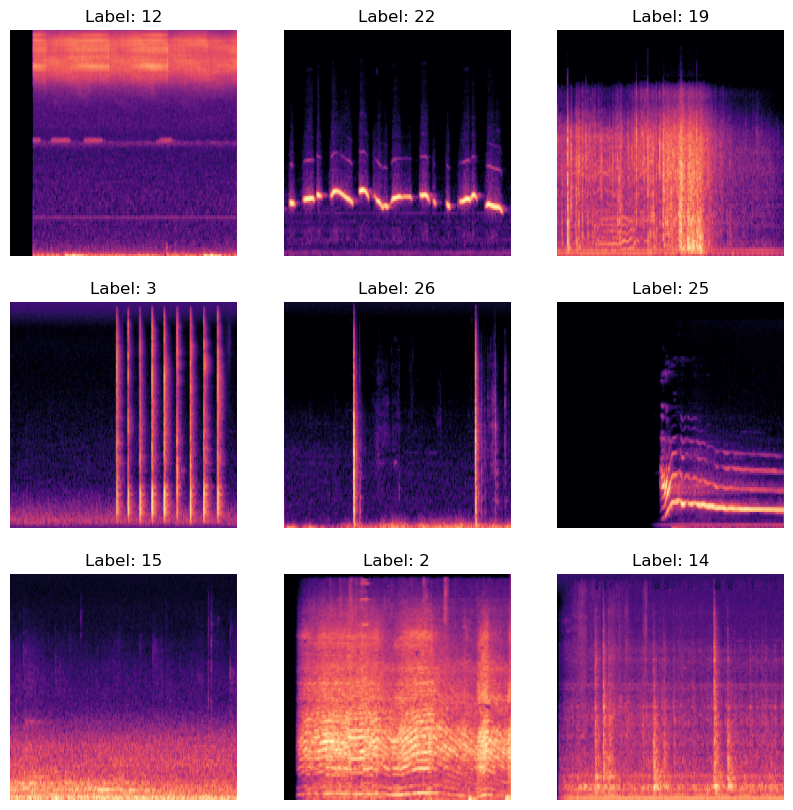

In [53]:
# Displaying a batch of images with labels from the training data
def visualize_data(data, num_images=9):
    # Extract a batch of images and labels
    images, labels = next(iter(data))
    
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()
visualize_data(train_data)

# They might appear black when you normalize the array

#### Normalising Data

In [55]:
# Normalising Numpy array
def normalise(image,label):
    image = tf.cast(image/255. , tf.float32)
    return image,label

train_data = train_data.map(normalise)
validation_data = validation_data.map(normalise)

#### Building a CNN Model

In [64]:
# Creating CNN model

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding="valid",activation="relu",input_shape=(256,256,3)))
model.add(MaxPooling2D((2,2),strides=2,padding="valid"))

model.add(Conv2D(64,kernel_size=(3,3),padding="valid",activation="relu"))
model.add(MaxPooling2D((2,2),strides=2,padding="valid"))

model.add(Conv2D(128,kernel_size=(3,3),padding="valid",activation="relu"))
model.add(MaxPooling2D((2,2),strides=2,padding="valid"))

model.add(Flatten())

model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(27,activation="softmax"))

C:\Users\kanis\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 27)                  │           1,755 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,987 (56.64 MB)

 Trainable params: 14,848,987 (56.64 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

#### Training the Model

In [70]:
history = model.fit(train_data,epochs=10,validation_data=validation_data)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.0482 - loss: 3.3835 - val_accuracy: 0.0519 - val_loss: 3.1725
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.0799 - loss: 3.1310 - val_accuracy: 0.2568 - val_loss: 2.7462
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2764 - loss: 2.6503 - val_accuracy: 0.4444 - val_loss: 2.0775
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4104 - loss: 2.0512 - val_accuracy: 0.5012 - val_loss: 1.7254
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5595 - loss: 1.5929 - val_accuracy: 0.7037 - val_loss: 1.1643
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7093 - loss: 1.0739 - val_accuracy: 0.7778 - val_loss: 0.7662
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7968 - loss: 0.7280 - val_accuracy: 0.8000 - val_loss: 0.6601
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7925 - loss: 0.7056 - val_accuracy: 0.8790 - val_loss:

#### Plotting Accuracy and Loss Graphs during Training and Validation

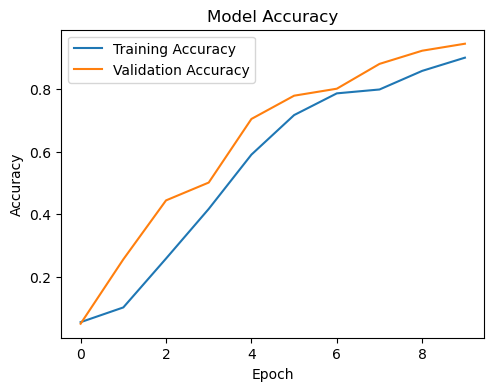

In [99]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

- INFERENCE: Less prone to overfitting as the seperation between both the curves is less.

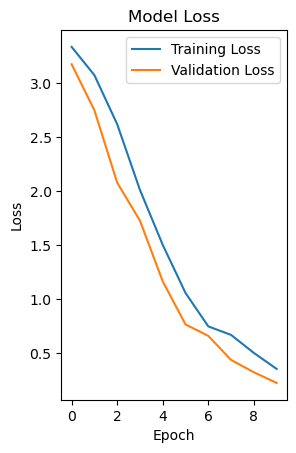

In [101]:
# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

- INFERENCE: Less prone to overfitting as the seperation between both the curves is less.

#### Predicting

In [110]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [172]:
import cv2
test_image = cv2.imread("12_11205.png")

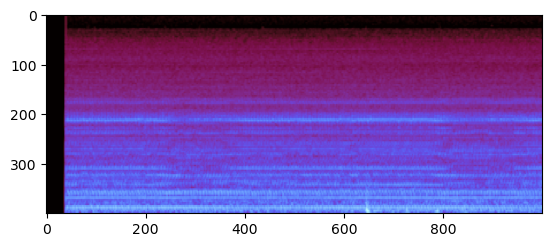

In [174]:
plt.imshow(test_image)

In [176]:
test_image.shape

(400, 1000, 3)

In [178]:
test_image=cv2.resize(test_image,(256,256))

In [180]:
test_input = test_image.reshape((1,256,256,3))

In [182]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [156]:
# generators(to process large amount of data) - Divide data into batches(only one batch loads in the RAM and when it is used it gets removed and new batch is loaded)
train_data = keras.utils.image_dataset_from_directory(
    directory=r"C:\Users\kanis\audio data\spectrogram\train",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(256,256)
)

validation_data = train_data = keras.utils.image_dataset_from_directory(
    directory=r"C:\Users\kanis\audio data\spectrogram\test",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(256,256)
)

print("Class names:", train_data.class_names)

# To view labels assigned to each image in a batch:
for images, labels in train_data.take(1):  # Take only one batch to inspect
    print("Batch of images shape:", images.shape)
    print("Batch of labels shape:", labels.shape)
    
    # Iterate over the batch and display label information
    for i in range(len(labels)):
        label = labels[i].numpy()
        class_name = train_data.class_names[label]
        print(f"Image {i + 1} has label index: {label} (Class name: {class_name})")

Found 1621 files belonging to 27 classes.
Found 405 files belonging to 27 classes.
Class names: ['Axe', 'BirdChirping', 'Chainsaw', 'Clapping', 'Fire', 'Firework', 'Footsteps', 'Frog', 'Generator', 'Gunshot', 'Handsaw', 'Helicopter', 'Insect', 'Lion', 'Rain', 'Silence', 'Speaking', 'Squirrel', 'Thunderstorm', 'TreeFalling', 'VehicleEngine', 'WaterDrops', 'Whistling', 'Wind', 'WingFlaping', 'WolfHowl', 'WoodChop']
Batch of images shape: (32, 256, 256, 3)
Batch of labels shape: (32,)
Image 1 has label index: 17 (Class name: Squirrel)
Image 2 has label index: 1 (Class name: BirdChirping)
Image 3 has label index: 16 (Class name: Speaking)
Image 4 has label index: 22 (Class name: Whistling)
Image 5 has label index: 21 (Class name: WaterDrops)
Image 6 has label index: 13 (Class name: Lion)
Image 7 has label index: 21 (Class name: WaterDrops)
Image 8 has label index: 17 (Class name: Squirrel)
Image 9 has label index: 0 (Class name: Axe)
Image 10 has label index: 13 (Class name: Lion)
Image 11